In [59]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/"
RES_DIR = ROOT_DIR + "resources/"
MOD_DIR = ROOT_DIR + "ml_models/"
BATCH_SIZE = 16

X = pd.read_csv(RES_DIR + "X_POS6.csv")["Sysnet"]
y = pd.read_csv(RES_DIR + "y_POS6.csv")["POS"]


In [60]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128
vocab_size = 25000  # Only consider the top 20k words
maxlen = 100  # Only consider the first 200 words of each movie review


In [61]:
X_pom, X_val, y_pom, y_val = train_test_split(X, y, test_size=.1, stratify=y, )
X_train, X_test, y_train, y_test = train_test_split(X_pom, y_pom, test_size=.2, stratify=y_pom, )

X_val = tf.convert_to_tensor(X_val, name ="Definicija")
y_val = tf.convert_to_tensor(y_val, name ="Sentiment")


X_train = tf.convert_to_tensor(X_train, name ="Definicija")
y_train = tf.convert_to_tensor(y_train, name ="Sentiment")

X_test = tf.convert_to_tensor(X_test, name ="Definicija")
y_test = tf.convert_to_tensor(y_test, name ="Sentiment")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [62]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [63]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [64]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [65]:
VOCAB_SIZE = 25000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode="int" )
encoder.adapt(train_dataset.map(lambda text, label: text))



In [66]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(1,), dtype=tf.string)
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = encoder(inputs)
x = embedding_layer(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
#activation="softmax"
model_POS = keras.Model(inputs=inputs, outputs=outputs)

## Train and Evaluate

In [67]:
model_POS.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["binary_accuracy"]
)
history = model_POS.fit(train_dataset, epochs=15,
                    validation_data=validation_dataset,
                    validation_steps=15)

Epoch 1/15
114/114 [==============================] - 24s 180ms/step - loss: 0.0938 - binary_accuracy: 0.9768 - val_loss: 0.0808 - val_binary_accuracy: 0.9844
Epoch 2/15
114/114 [==============================] - 22s 197ms/step - loss: 0.0760 - binary_accuracy: 0.9853 - val_loss: 0.0792 - val_binary_accuracy: 0.9844
Epoch 3/15
114/114 [==============================] - 22s 195ms/step - loss: 0.0601 - binary_accuracy: 0.9854 - val_loss: 0.0653 - val_binary_accuracy: 0.9844
Epoch 4/15
114/114 [==============================] - 20s 173ms/step - loss: 0.0338 - binary_accuracy: 0.9885 - val_loss: 0.0816 - val_binary_accuracy: 0.9854
Epoch 5/15
114/114 [==============================] - 22s 197ms/step - loss: 0.0146 - binary_accuracy: 0.9941 - val_loss: 0.0940 - val_binary_accuracy: 0.9849
Epoch 6/15
114/114 [==============================] - 20s 176ms/step - loss: 0.0109 - binary_accuracy: 0.9956 - val_loss: 0.1063 - val_binary_accuracy: 0.9839
Epoch 7/15
114/114 [==========================

In [68]:
model_POS.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 token_and_position_embeddin  (None, None, 64)         1606400   
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, None, 64)         74944     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_2   (None, 64)               0   

In [69]:
y_proba = model_POS.predict(X_test)
y_classes = tf.round((y_proba))
#y_classes = tf.round(tf.nn.sigmoid(y_proba))

114/114 [==============================] - 2s 13ms/step


In [70]:
y_classes[5:]

<tf.Tensor: shape=(3615, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)>

In [71]:
y_proba[5:]

array([[5.07264360e-07],
       [5.37575318e-07],
       [1.02185195e-05],
       ...,
       [7.55814314e-01],
       [2.32008460e-06],
       [1.18685864e-06]], dtype=float32)

In [72]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_classes).numpy()


In [73]:
con_mat

array([[3537,   30],
       [  40,   13]], dtype=int32)

In [74]:
from keras.utils.vis_utils import plot_model

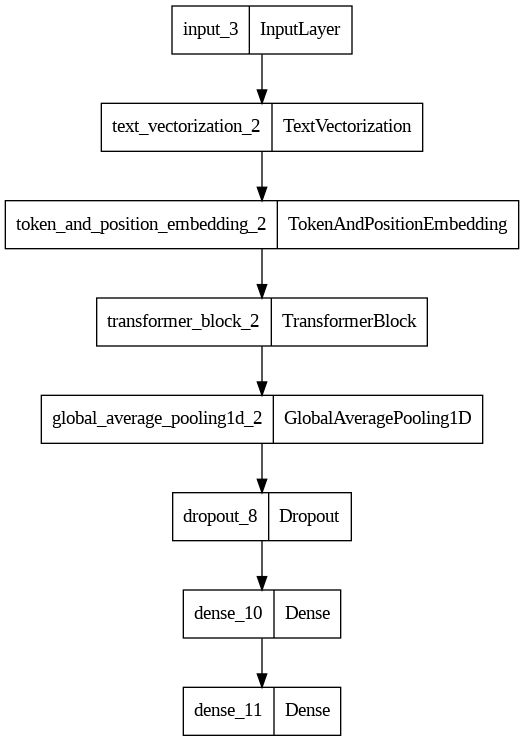

In [75]:
plot_model(model_POS)

In [76]:
def polarity_correction(pos, neg):
  one = tf.convert_to_tensor(1.0)
  ret_pos = pos*(one - neg)
  ret_neg =neg * (one -pos)
  return ret_pos, ret_neg
  

In [77]:
X = pd.read_csv(RES_DIR + "X_NEG6.csv")["Sysnet"]
y = pd.read_csv(RES_DIR + "y_NEG6.csv")["NEG"]

In [78]:
X_pom, X_val, y_pom, y_val = train_test_split(X, y, test_size=.1, stratify=y, )
X_train, X_test, y_train, y_test = train_test_split(X_pom, y_pom, test_size=.2, stratify=y_pom, )

X_val = tf.convert_to_tensor(X_val, name ="Definicija")
y_val = tf.convert_to_tensor(y_val, name ="Sentiment")


X_train = tf.convert_to_tensor(X_train, name ="Definicija")
y_train = tf.convert_to_tensor(y_train, name ="Sentiment")

X_test = tf.convert_to_tensor(X_test, name ="Definicija")
y_test = tf.convert_to_tensor(y_test, name ="Sentiment")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [79]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [80]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode="int" )
encoder.adapt(train_dataset.map(lambda text, label: text))



In [81]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(1,), dtype=tf.string)
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = encoder(inputs)
x = embedding_layer(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
#activation="softmax"
model_NEG = keras.Model(inputs=inputs, outputs=outputs)

In [82]:
model_NEG.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["binary_accuracy"]
)
history = model_NEG.fit(train_dataset, epochs=15,
                    validation_data=validation_dataset,
                    validation_steps=15)

Epoch 1/15
114/114 [==============================] - 26s 188ms/step - loss: 0.1021 - binary_accuracy: 0.9744 - val_loss: 0.0852 - val_binary_accuracy: 0.9828
Epoch 2/15
114/114 [==============================] - 23s 201ms/step - loss: 0.0781 - binary_accuracy: 0.9829 - val_loss: 0.0728 - val_binary_accuracy: 0.9828
Epoch 3/15
114/114 [==============================] - 21s 181ms/step - loss: 0.0498 - binary_accuracy: 0.9854 - val_loss: 0.0870 - val_binary_accuracy: 0.9828
Epoch 4/15
114/114 [==============================] - 23s 199ms/step - loss: 0.0192 - binary_accuracy: 0.9926 - val_loss: 0.1026 - val_binary_accuracy: 0.9802
Epoch 5/15
114/114 [==============================] - 21s 181ms/step - loss: 0.0106 - binary_accuracy: 0.9952 - val_loss: 0.1118 - val_binary_accuracy: 0.9786
Epoch 6/15
114/114 [==============================] - 23s 200ms/step - loss: 0.0090 - binary_accuracy: 0.9961 - val_loss: 0.1224 - val_binary_accuracy: 0.9760
Epoch 7/15
114/114 [==========================

In [83]:
y_proba = model_POS.predict(X_test)
y_classes = tf.round((y_proba))
#y_classes = tf.round(tf.nn.sigmoid(y_proba))

114/114 [==============================] - 2s 15ms/step


In [84]:
y_classes[5:]

<tf.Tensor: shape=(3615, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [85]:
y_proba[5:]

array([[5.3020852e-07],
       [5.0669723e-07],
       [6.0213910e-07],
       ...,
       [9.3465701e-07],
       [6.2045899e-07],
       [4.0464826e-07]], dtype=float32)

In [86]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_classes).numpy()


In [87]:
con_mat

array([[3516,   43],
       [  59,    2]], dtype=int32)

In [88]:
sword = pd.read_csv(RES_DIR +"definicije_lematizone.csv", index_col=0)

In [89]:
definicije = sword["Definicija"]

In [90]:
tensor_def = tf.convert_to_tensor(definicije.to_numpy(dtype='str'))

In [91]:
tn_POS = model_POS.predict(tensor_def)
tn_NEG = model_NEG.predict(tensor_def)


792/792 [==============================] - 10s 12ms/step


In [92]:
tn_POSc, tn_NEGc = polarity_correction(tn_POS, tn_NEG)

In [93]:
sword["POS"] = tn_POSc.numpy()

In [94]:
sword["NEG"] = tn_NEGc.numpy()

In [95]:
sword

,ID,Definicija,POS,NEG
0,ENG30-03574555-n,zgrada u koji se nalaziti organizacioni jedini...,4.661425e-07,0.000004
1,ENG30-07810907-n,pripremljen dodatak jela za poboljšanje ukus,4.787433e-07,0.000003
2,ENG30-00721431-n,"u nečiji prilika , mogućnost",7.030554e-07,0.000019
3,ENG30-00473799-v,ostati jesam još samo da se doterati neki fine...,4.919704e-07,0.000006
4,ENG30-00903385-v,zapad on jesam oprostiti što se nekada računat...,5.920776e-07,0.000008
...,...,...,...,...
25315,ENG30-15266265-n,mandat predsednik,7.293049e-07,0.000006
25316,ENG30-15266685-n,vreme između početak i kraj vremenski perioda,4.124454e-07,0.000004
25317,ENG30-15266911-n,tačka u vreme kada se nešto završavati,4.657864e-07,0.000004
25318,ENG30-15276642-n,( računarstvo ) brzina prenos podatak ( npr . ...,4.005143e-07,0.000003


In [96]:
sword.to_csv(RES_DIR + "sentiment_transformer6.csv")